In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
from scipy.stats import normaltest
from scipy.special import factorial
from scipy.linalg import solve, det
from functools import reduce

In [2]:
!pip install -q sociophysicsDataHandler 
from sociophysicsDataHandler import SociophysicsDataHandler
dh = SociophysicsDataHandler()
p = """guest
YDPGL-XREXC-QGMZS-UAKES"""
c = """text_file = open("auth.txt", "w+");text_file.write(p);text_file.close()""" 
exec(c)

In [3]:
df = pd.read_csv('CompressedData ehv all multibin.csv')
#df['hour'] = pd.to_datetime(df['Unnamed: 0']*10**6).dt.hour
for index in df.columns[4:]:
    df[index] = df[index]
    
df = df.drop(['p_left', 'p_right'], axis=1).drop(['1, 2', '1, 3'], axis=1)

#df = df.reindex(columns=np.flip(df.columns))

df = df.iloc[::1]

#np.corrcoef(df.iloc[0:-1]['0, 0'], df.iloc[1:]['0, 0'])
df

,Unnamed: 0,N,"0, 0","1, 0","2, 0","0, 1","1, 1","2, 1","0, 2","2, 2","0, 3","2, 3","0, 4","1, 4","2, 4","0, 5","1, 5","2, 5"
0,1.617093e+12,34,2.0,5.0,1.0,1.0,3.0,2.0,3.0,4.0,2.0,0.0,1.0,0.0,1.0,4.0,0.0,0.0
1,1.617093e+12,16,4.0,0.0,3.0,0.0,2.0,2.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.617093e+12,27,1.0,2.0,2.0,0.0,3.0,2.0,5.0,6.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0
3,1.617093e+12,29,0.0,2.0,3.0,0.0,4.0,2.0,0.0,3.0,0.0,5.0,0.0,3.0,1.0,0.0,0.0,1.0
4,1.617093e+12,38,0.0,5.0,2.0,1.0,3.0,4.0,1.0,4.0,0.0,5.0,0.0,6.0,2.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175634,1.668380e+12,17,0.0,2.0,2.0,0.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,1.0,0.0
175635,1.668380e+12,18,0.0,2.0,3.0,1.0,8.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
175636,1.668380e+12,24,0.0,3.0,0.0,1.0,10.0,3.0,0.0,4.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0
175637,1.668380e+12,39,0.0,6.0,2.0,2.0,11.0,9.0,0.0,3.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0


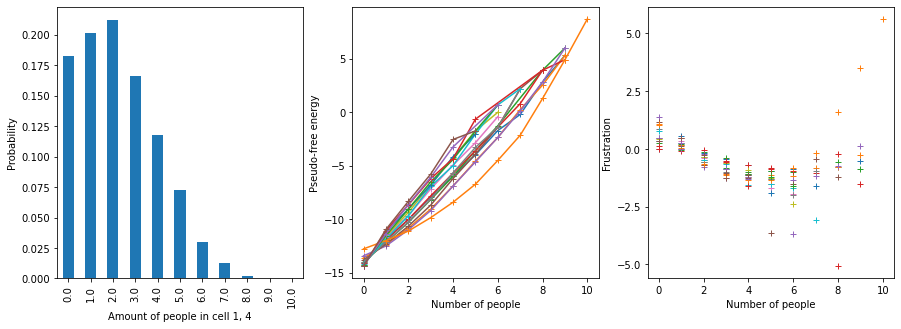

In [45]:
n = 10

def combinations(N, n, b):
    return factorial(n-N+b-2)/(factorial(n-N)*factorial(b-2))

l = df[df['N']==n]['0, 1'].count()
mn = (df[df['N'] == n]['0, 0']*n).mean()

#ax1 = (df[df['N'] == n]['p_right']*n).hist(bins=10)

trs = []
xs = []
pbs = []
for index in df.columns[2:]:
    pb = (df[df['N'] == n]).groupby(index).count()['N']/l
    pbs.append(pb)

    x = df[df['N'] == n].groupby(index).count().index
    xs.append(x)
    
    tr = -np.log(combinations(x, n, 16)*pb[x])
    trs.append(tr)

M = generate_matrix(len(xs), xs, compare='neigh')
f = generate_f(trs, xs, compare='neigh')

sol = solve(M.T*M, M.T*f)

df_sol = pd.DataFrame(index=df.columns[2:], columns=['v', 'z'])

df_sol['v'] = sol[::2]
df_sol['z'] = sol[1::2]



fig, ax = plt.subplots(1, 3, sharey=False, figsize=(15, 5))

frs = []

for i in range(len(trs)):
    trs[i].plot(ax=ax[1], marker='+')
    
    frs.append(trs[i] - sol[2*i, 0]*xs[i] - sol[2*i+1, 0])
    
    ax[2].plot(xs[i], (trs[i] - sol[2*i, 0]*xs[i] - sol[2*i+1, 0]), '+')
    ax[2].set_ylabel('Frustration')
    
    ax[1].set_xlabel('Number of people')
    ax[1].set_ylabel('Pseudo-free energy')
    ax[2].set_xlabel('Number of people')
    
    ax[2].yaxis.set_major_locator(plt.MaxNLocator(5))
    
    pbs[11].plot(kind='bar', ax=ax[0])
    ax[0].set_xlabel('Amount of people in cell 1, 4')
    ax[0].set_ylabel('Probability')
    
    #ax[1].set_xlim(0, 150)
    
#pbs = pd.DataFrame(index=df.columns[:-2], data=)
a = pd.concat(frs, axis=1).mean(axis=1).to_dict()

plt.savefig('collapse.png')

In [25]:
def generate_matrix(m, xs, compare='neigh'):

# system:
# (v1 - v2) x(n) + (z1 - z2) = f1(n) - f2(n), for n = 0, 1, 2, 3, 4, 5, ..
# (v2 - v3) x(n) + (z2 - z3) = f2(n) - f3(n), for n = 0, 1, 2, 3, 4, 5, ..
# ..
# (v_{m-1} - v_m) x(n) + (z_{m-1} - z_m) = f_{m-1}(n) - f_m(n)
# z1 = f1(0)
# v1 x(1) + z1 = f1(1)
    Ms = []

    for i in range(m-1):
        if compare=='neigh':
            x = np.intersect1d(xs[i], xs[i+1])
        if compare=='ref':
            x = np.intersect1d(xs[0], xs[i+1])
        
        M_i = np.matrix(np.zeros((len(x), m*2)))

        if compare == 'neigh':
            mask = np.matrix([[((j >= i*2) and (j < i*2 + 4)) for j in range(m*2)] for _ in x])
        elif compare == 'ref':
            mask = np.matrix([[((j >= i*2+2) and (j < i*2 + 4)) or (j <2) for j in range(m*2)] for _ in x])
        
        values = np.matrix([[xt, 1, -xt, -1] for xt in x])

        np.place(M_i, mask, values)

        Ms.append(M_i)

    Mcond = np.matrix(np.zeros((2, m*2)))
    Mcond[0, 1] = 1
    #Mcond[1, 2:4] = [1, 1]
    Mcond[1, 0] = 1

    Ms.append(Mcond)

    return np.concatenate(Ms)

def generate_f(trs, xs, compare='neigh'):
    fs = []
    
    for i in range(len(trs)-1):
        if compare=='neigh':
            x = np.intersect1d(xs[i], xs[i+1])
            fs.append(trs[i][x].to_numpy().reshape(len(trs[i][x]), 1) - trs[i+1][x].to_numpy().reshape(len(trs[i+1][x]), 1))
        elif compare=='ref':
            x = np.intersect1d(xs[0], xs[i+1])
            fs.append(trs[0][x].to_numpy().reshape(len(trs[0][x]), 1) - trs[i+1][x].to_numpy().reshape(len(trs[i+1][x]), 1))
            
    fcond = np.array([[trs[0][0]],
                      [(trs[0].iloc[1] - trs[0].iloc[0])/(x[1]-x[0])]])
    #                  [trs[1].iloc[1]]])
    
    fs.append(fcond)
        
    return np.concatenate(fs)

M = generate_matrix(len(xs), xs, compare='ref')
f = generate_f(trs, xs, compare='ref')

M.shape, f.shape

((122, 32), (122, 1))

trying to fetch: /storage/surfsara/ProRail_USE_LL_data/ehv/background_images/EHV.Perron2.1_multisensor.png
background fetched. Accessible as <this-object>.bg
0, 0 0.5643192694732961
1, 0 0.43986494551976996
2, 0 0.5943045285974842
0, 1 0.4872841413576699
1, 1 0.4052290125265798
2, 1 0.4970645235431653
0, 2 0.5817786861737726
2, 2 0.5823860268669974
0, 3 0.6720063799829886
2, 3 0.6260515918028056
0, 4 0.5611718165659974
1, 4 0.15455918671888347
2, 4 0.7961787621776908
0, 5 0.9108535238477877
1, 5 1.0
2, 5 0.9057459683829259


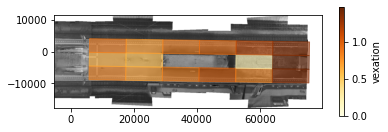

In [11]:
df_geometry = pd.read_csv('Geometry ehv all multibin.csv').set_index('Unnamed: 0')

cmap = mpl.cm.get_cmap('YlOrBr')

dh.fetch_background_image_from_path('ehv/background_images/EHV.Perron2.1_multisensor.png')
image = dh.bg
plt.imshow(image, extent=[-5134, 75135, -17731, 11645])
for i in df_geometry.index:

    x = [list(eval(a))[0] for a in df_geometry.loc[i].to_list()]
    y = [list(eval(a))[1] for a in df_geometry.loc[i].to_list()]

    try:
        im = plt.fill(x, y, color=cmap((df_sol['v']/df_sol['v'].max())[i]), alpha=0.6)
        print(i, (df_sol['v']/df_sol['v'].max())[i])
    except:
        pass
    
cax = mpl.cm.ScalarMappable(cmap=cmap)
cax.set_array(np.array([0, 1])*df_sol['v'].max())
plt.colorbar(cax, shrink=0.5, label='vexation')
plt.savefig('heatmap vexation.png')

In [246]:
pd.concat([trs[1] - sol[2*1, 0]*xs[1] - sol[2*1+1, 0], trs[2] - sol[2*2, 0]*xs[2] - sol[2*2+1, 0]], axis=1)

,0,1
0.00,-1.266785,-0.729855
0.05,-0.223398,-0.172962
0.10,1.057614,1.004927
0.15,2.529448,2.534137
0.20,4.168313,4.111232
0.25,5.914149,5.620579
0.30,7.471192,7.082835
0.35,9.481721,9.410738
0.40,11.219775,9.966753
0.45,12.390248,13.038447


In [329]:
df_sol

,v,z
"0, 0",1.338599,0.356555
"1, 0",1.368962,-0.173490
"2, 0",1.496567,-0.008778
"0, 1",1.406994,0.342523
"1, 1",1.422646,-0.337194
"2, 1",1.641348,-0.522192
"0, 2",1.829997,-0.226128
"2, 2",1.700221,-0.402802
"0, 3",1.965166,-0.215072
"2, 3",2.014533,-0.505817


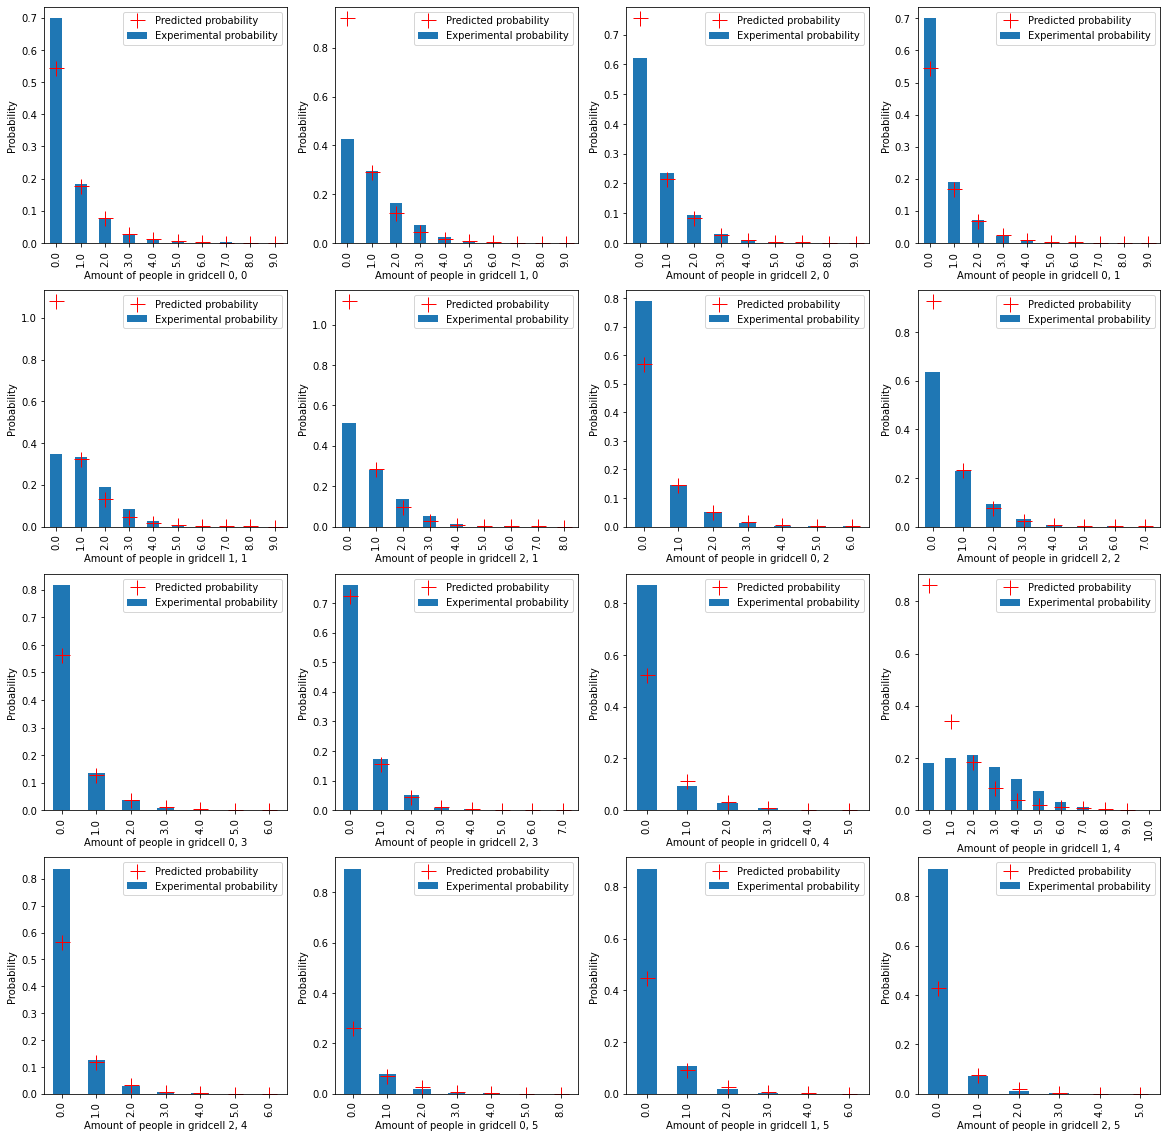

In [30]:
x = np.arange(0, n)

f = np.vectorize(lambda x: a[x])

fig, ax = plt.subplots(4, 4, figsize=(20, 20))

ax = ax.flatten()

#i = 2

for i in range(0, 16):

    ax[i].plot(x, np.exp(x*-df_sol.loc[df.columns[i+2]]['v'])*np.exp(-f(x))/(np.exp(df_sol.loc[df.columns[i+2]]['z'])*factorial(x)), 'r+', markersize=15)

    pbs[i].plot(kind='bar', ax=ax[i])

    ax[i].legend(['Predicted probability','Experimental probability'])
    ax[i].set_xlabel(f'Amount of people in gridcell {df.columns[i+2]}')
    ax[i].set_ylabel('Probability')
    
plt.savefig('Probabilities.png')

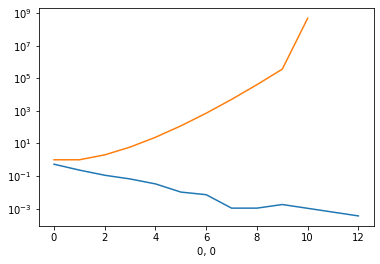

In [16]:
pbs[0].plot()
plt.plot(factorial(xs[0]))
plt.yscale('log')

### df.iloc[::100].groupby('N').count()['0, 0'][30]

In [46]:
df

,Unnamed: 0,N,"0, 0","1, 0","2, 0","0, 1","1, 1","2, 1","0, 2","2, 2","0, 3","2, 3","0, 4","1, 4","2, 4","0, 5","1, 5","2, 5"
0,1.617093e+12,34,2.0,5.0,1.0,1.0,3.0,2.0,3.0,4.0,2.0,0.0,1.0,0.0,1.0,4.0,0.0,0.0
1,1.617093e+12,16,4.0,0.0,3.0,0.0,2.0,2.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.617093e+12,27,1.0,2.0,2.0,0.0,3.0,2.0,5.0,6.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0
3,1.617093e+12,29,0.0,2.0,3.0,0.0,4.0,2.0,0.0,3.0,0.0,5.0,0.0,3.0,1.0,0.0,0.0,1.0
4,1.617093e+12,38,0.0,5.0,2.0,1.0,3.0,4.0,1.0,4.0,0.0,5.0,0.0,6.0,2.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175634,1.668380e+12,17,0.0,2.0,2.0,0.0,8.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0.0,0.0,1.0,0.0
175635,1.668380e+12,18,0.0,2.0,3.0,1.0,8.0,1.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
175636,1.668380e+12,24,0.0,3.0,0.0,1.0,10.0,3.0,0.0,4.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0
175637,1.668380e+12,39,0.0,6.0,2.0,2.0,11.0,9.0,0.0,3.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0
